<a href="https://colab.research.google.com/github/Jeet1309/AI-ML-tss/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AE 244 ASSIGNMENT**

# **IMPORTED FUNCTION**

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math
from scipy.integrate import simps
import sympy as sp
dx = 0.02
n = 50
n*dx

1.0

# **USER DEFINED FUNCTION**

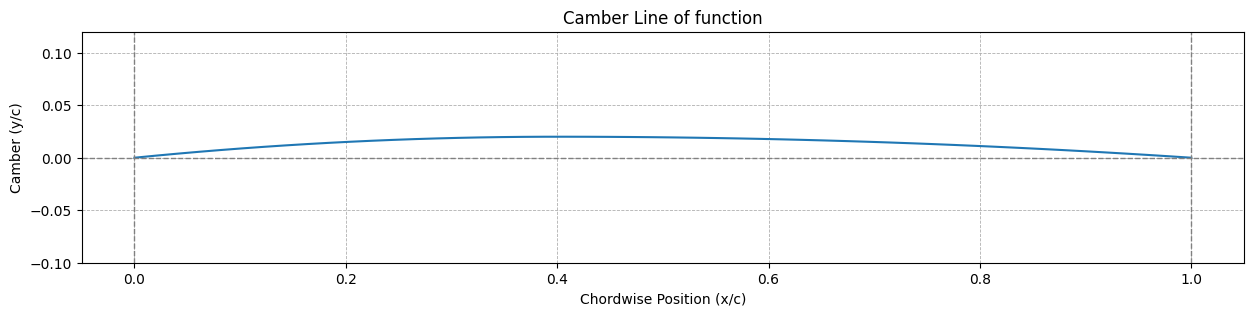

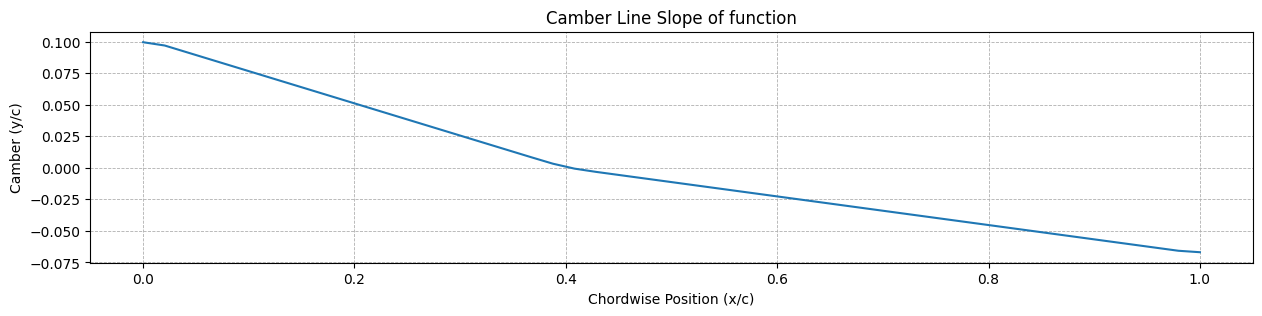

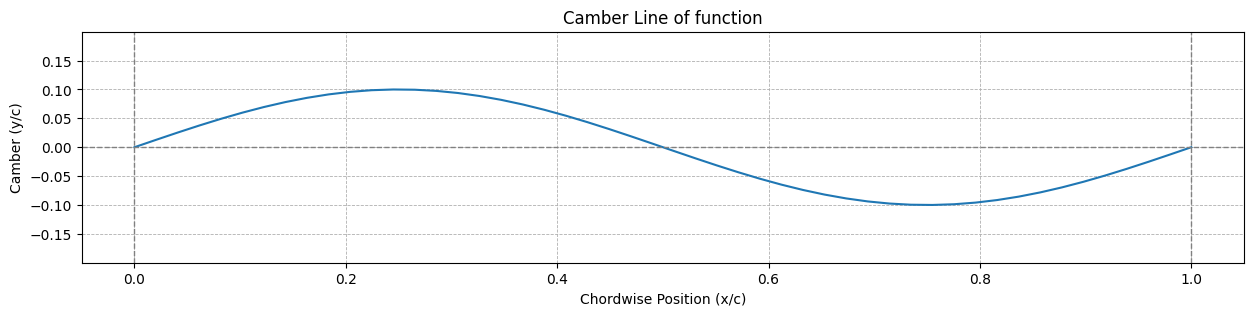

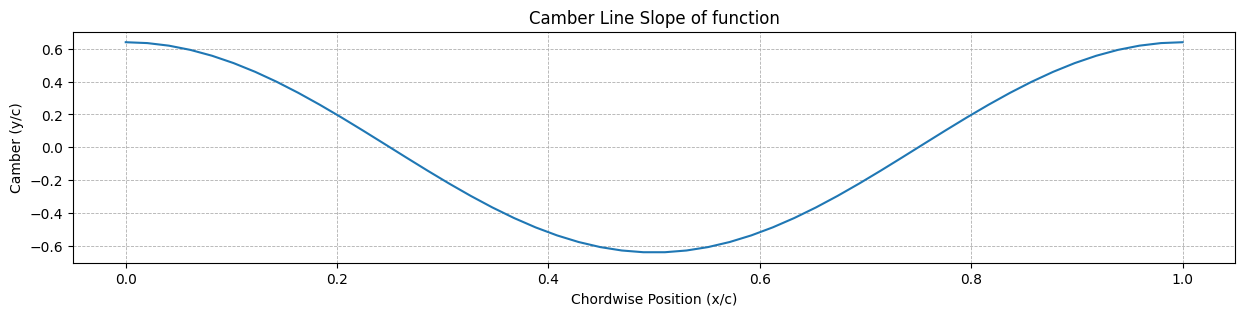

In [193]:
def camber_line(x, y):
    plt.figure(figsize=(15,3))
    plt.plot(x, y)
    plt.ylim((min(y)-0.1, max(y) +0.1))
    plt.xlabel("Chordwise Position (x/c)")
    plt.ylabel("Camber (y/c)")
    plt.title(f"Camber Line of function")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Chord line
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)  # Leading edge
    plt.axvline(1, color='gray', linestyle='--', linewidth=1)  # Trailing edge
    plt.grid(True, linestyle="--", linewidth=0.6)
    plt.show()
def camber_slope(y,dx=dx):
  y_slope = np.gradient(y, dx)
  plt.figure(figsize=(15,3))
  a = np.linspace(0, 1, n)
  plt.plot(a,y_slope)
  plt.xlabel("Chordwise Position (x/c)")
  plt.ylabel("Camber (y/c)")
  plt.title(f"Camber Line Slope of function")
  plt.grid(True, linestyle="--", linewidth=0.6)
  plt.show()

def naca_camber_line(x, m, p, c=1):
    """
    Computes the camber line of a NACA 4-digit airfoil.

    Parameters:
    - x: Chordwise position (array)
    - m: Maximum camber
    - p: Position of maximum camber
    - c: Chord length (default = 1)

    Returns:
    - y_camber: Camber line y-coordinates
    """
    y_camber = np.where(
        x < p * c,
        (m / p**2) * (2 * p * (x / c) - (x / c)**2),
        (m / (1 - p)**2) * ((1 - 2 * p) + 2 * p * (x / c) - (x / c)**2)
    )
    return y_camber

def generate_camber_line(camber_func, x_range=(0, 1), num_points=n, **kwargs):
    """
    Generates and plots the camber line for a given function.

    Parameters:
    - camber_func: A function defining the camber line y = f(x)
    - x_range: Tuple defining the range of x (default: (0,1) for chord length)
    - num_points: Number of points for smooth plotting (default: 100)
    - kwargs: Additional parameters for specific camber functions (e.g., NACA airfoils)

    Returns:
    - x: x-coordinates of the camber line
    - y: y-coordinates of the camber line
    """
    x = np.linspace(x_range[0], x_range[1], num_points)

    if isinstance(camber_func, str) and camber_func.startswith("NACA"):
        # Extract camber parameters from NACA 4-digit airfoil
        m = int(camber_func[4]) / 100  # Maximum camber
        p = int(camber_func[5]) / 10   # Position of max camber
        y = naca_camber_line(x, m, p)
        label = f"NACA {camber_func}"
    else:
        # Use user-defined function
        y = camber_func(x, **kwargs)
        label = camber_func.__name__

    # Plot camber line


    return x, y
# Example Usage:

# (1) Using a NACA 2412 airfoil camber line
x,y  = generate_camber_line("NACA2412")
camber_line(x,y)
camber_slope(y)
# (2) Using a custom parabolic camber function
custom_camber = lambda x: 0.1*np.sin(2*x*np.pi)  # Simple parabolic shape
x,y = generate_camber_line(custom_camber)
camber_line(x,y)
camber_slope(y)

#**COEFFICIENT OF LIFT AND MOMENT CALCULATION**

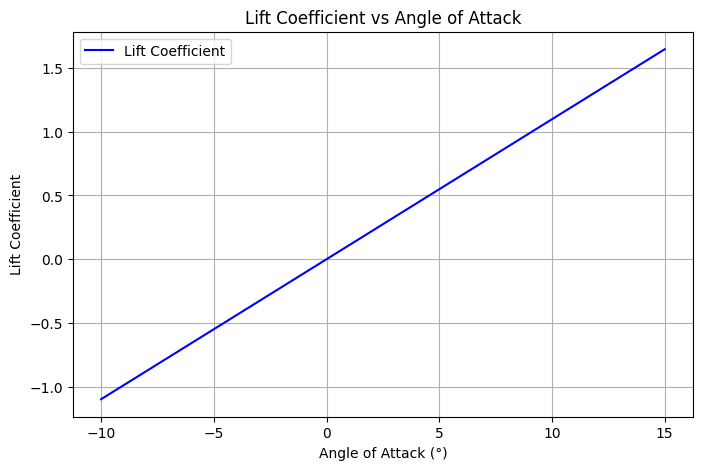

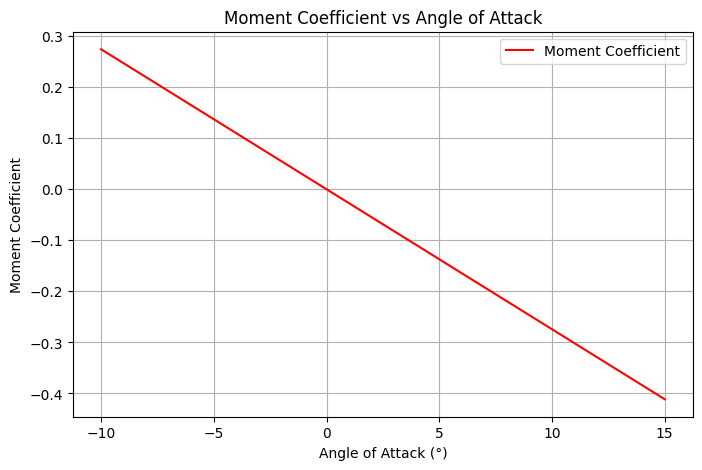

In [209]:
def plot_graphs_vs_alpha(alphas,y,Label,color):
  plt.figure(figsize=(8, 5))
  plt.plot(alphas, y, label=Label, color=color)
  plt.xlabel("Angle of Attack (°)")
  plt.ylabel(f"{Label}")
  plt.title(f"{Label} vs Angle of Attack")
  plt.legend()
  plt.grid()
  plt.show()

def compute_airfoil_coefficients(alpha, naca):
    """
    Computes the lift coefficient (Cl) and moment coefficient (Cm)
    for a cambered airfoil based on thin airfoil theory.

    Parameters:
    - alpha: Angle of attack in degrees (or array of values)
    - naca: String containing the NACA 4-digit airfoil code

    Returns:
    - alpha: Array of angle of attack values (degrees)
    - Cl_values: Lift coefficient values
    - Cm_values: Moment coefficient values about quarter chord
    """
    M, P = int(naca[0])+ 1e-8, int(naca[1])+1e-8  # Extract max camber (M) and position (P)
    M = M / 100  # Convert percentage to decimal
    P = P / 10   # Convert fraction

    # Generate theta values from 0 to π
    theta = np.linspace(0, np.pi, 10001)
    dtheta = np.pi / 10001  # Small step size for integration

    # Compute x/c values along the chord line
    d = 0.5 * (1 - np.cos(theta))

    # Compute slope dy/dx (dz/dx)
    slope = np.zeros_like(theta)
    mask1 = d <= P
    mask2 = d > P
    slope[mask1] = ((2 * M) / (P ** 2)) * (P - d[mask1]) * 0.5 * np.sin(theta[mask1])
    slope[mask2] = ((2 * M) / ((1 - P) ** 2)) * (P - d[mask2]) * 0.5 * np.sin(theta[mask2])

    # Compute integrals using trapezoidal rule
    sum1 = np.trapz(slope * np.cos(theta), theta)  # ∫ (dy/dx) cos(θ) dθ
    sum2 = np.trapz(slope, theta)                 # ∫ (dy/dx) dθ
    sum3 = np.trapz(slope * np.cos(2 * theta), theta)  # ∫ (dy/dx) cos(2θ) dθ

    # Convert alpha to radians
    alpha_rad = np.radians(alpha)

    # Compute Cl and Cm
    Cl = 2 * np.pi * alpha_rad + sum1 - (2 * sum2)
    Cm = -0.25 * (Cl + 2 * (sum1 - sum3))

    return alpha, Cl, Cm, slope, sum2, theta

# Example usage
alpha_values = np.linspace(-10, 15, 100)  # Range of angles of attack
naca_code = "0012"  # Example: NACA 2412 airfoil

Cl_values, Cm_values = [], []
aoa_values = []
for alpha in alpha_values:
    aoa, Cl, Cm, _, _, _ = compute_airfoil_coefficients(alpha, naca_code)
    aoa_values.append(aoa)
    Cl_values.append(Cl)
    Cm_values.append(Cm)

# Example usage

# Camber location

# alphas = np.linspace(0, 18, 100)  # Angles of attack from 0 to 18 degrees
# alpha_rad = np.radians(alphas)  # Convert to radians

# Cl_values = []
# Cm_values = []
# alphas, Cl, Cm, slope, sum2, theta = compute_airfoil_coefficients(str(input('naca')))
plot_graphs_vs_alpha(aoa_values,Cl_values,'Lift Coefficient','blue')
plot_graphs_vs_alpha(aoa_values,Cm_values,'Moment Coefficient','red')
# compute_airfoil_coefficients(alpha= input('aoa'),naca= input('naca'))

# **FINDING CIRCULATION**

Enter the angle of attack (in degrees): 4
Enter the NACA airfoil number: 2415
Enter the freestream velocity: 25


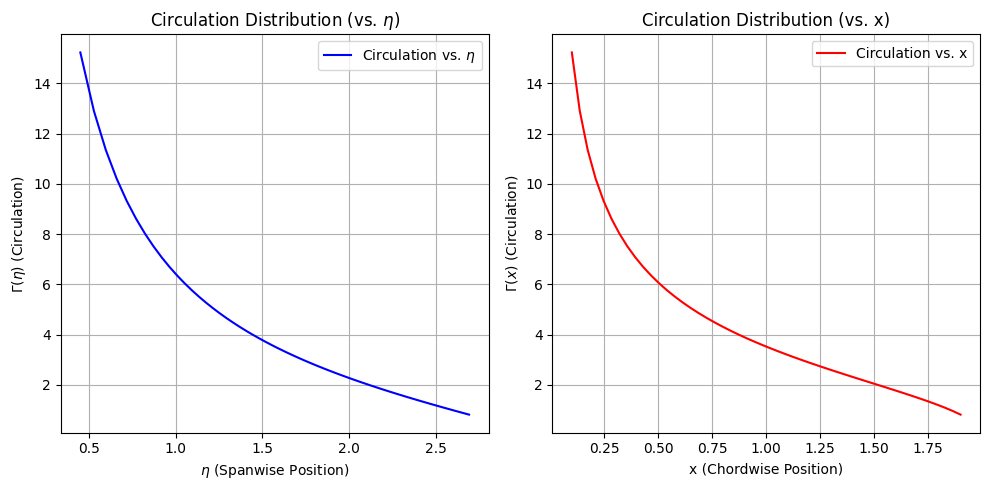

In [202]:
import numpy as np
import matplotlib.pyplot as plt

def compute_circulation(alpha, naca, u_free):
    """
    Computes the circulation distribution along the airfoil.

    Parameters:
    - alpha: Angle of attack in degrees
    - naca: NACA airfoil number (used in compute_airfoil_coefficients)
    - u_free: Freestream velocity

    Returns:
    - eta: Discretized spanwise positions (zeta transformed)
    - x: Corresponding x-coordinates (chordwise positions)
    - circulation_theta: Circulation values along the airfoil
    """
    alphas, Cl, Cm, slope, sum2, theta = compute_airfoil_coefficients(alpha,naca)

    # Generate eta values based on zeta transformation
    zeta = np.linspace(0.05, 0.95, 50)  # Avoid singularity at 0 and 1
    eta = np.arccos(1 - (2 * zeta))  # Transformation for spanwise positions
    x = 1 - np.cos(eta)  # Convert eta to x-coordinates

    circulation_theta = []

    for f in range(len(eta)):
        sumz = 0

        for p in range(1, 50):
            suma = np.sum(((2 / np.pi) * (slope * np.cos(p * theta) * (np.pi / 10001))) * np.sin(eta[f]))
            sumz += suma

        circulation = (2 * u_free) * (((alpha * np.pi) / 180 - (1 / np.pi) * sum2) * ((1 + np.cos(eta[f])) / np.sin(eta[f])) + sumz)
        circulation_theta.append(circulation)

    return eta, x, circulation_theta

def plot_circulation(eta, x, circulation_theta):
    """Plots the circulation distribution along the airfoil."""
    plt.figure(figsize=(10, 5))

    # Plot circulation vs. eta
    plt.subplot(1, 2, 1)
    plt.plot(eta, circulation_theta, label='Circulation vs. $\eta$', color='b')
    plt.xlabel(r'$\eta$ (Spanwise Position)')
    plt.ylabel(r'$\Gamma(\eta)$ (Circulation)')
    plt.title('Circulation Distribution (vs. $\eta$)')
    plt.legend()
    plt.grid()

    # Plot circulation vs. x (chordwise position)
    plt.subplot(1, 2, 2)
    plt.plot(x, circulation_theta, label='Circulation vs. x', color='r')
    plt.xlabel('x (Chordwise Position)')
    plt.ylabel(r'$\Gamma(x)$ (Circulation)')
    plt.title('Circulation Distribution (vs. x)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Inputs
alpha = float(input("Enter the angle of attack (in degrees): "))
naca = str(input("Enter the NACA airfoil number: "))
u_free = float(input("Enter the freestream velocity: "))

eta, x, circulation_theta = compute_circulation(alpha, naca, u_free)
plot_circulation(eta, x, circulation_theta)
# print(circulation_theta.size)

In [203]:
circulation_theta


[15.229500463484937,
 12.90191688619607,
 11.345030079591634,
 10.20544803549375,
 9.321848332978572,
 8.608667386869072,
 8.01572052421836,
 7.511358425562101,
 7.07449309461169,
 6.69045344332372,
 6.3486704433375705,
 6.041307794843691,
 5.762413011099212,
 5.507370149568395,
 5.27253512198688,
 5.0549856573707075,
 4.852345580206591,
 4.662658603811084,
 4.484295922547048,
 4.3158873734002405,
 4.156269348506213,
 4.004444815851535,
 3.8595522251242844,
 3.720841021354286,
 3.587652130532642,
 3.459402223786736,
 3.3355708760964733,
 3.2156899544915207,
 3.099334726918467,
 2.986116294836427,
 2.875675032249155,
 2.7676747693083796,
 2.6617974948750476,
 2.5577383722875995,
 2.455200866868363,
 2.3538917711509812,
 2.2535158805994544,
 2.15377001110568,
 2.0543359460842114,
 1.9548717312303374,
 1.8550004553295731,
 1.7542951852203645,
 1.6522579069610885,
 1.5482888502580765,
 1.4416397692419978,
 1.3313390820480173,
 1.2160643887327554,
 1.0939080770386076,
 0.9619001149938016,
 

Bound Circulation: 133.7024
(50, 50)


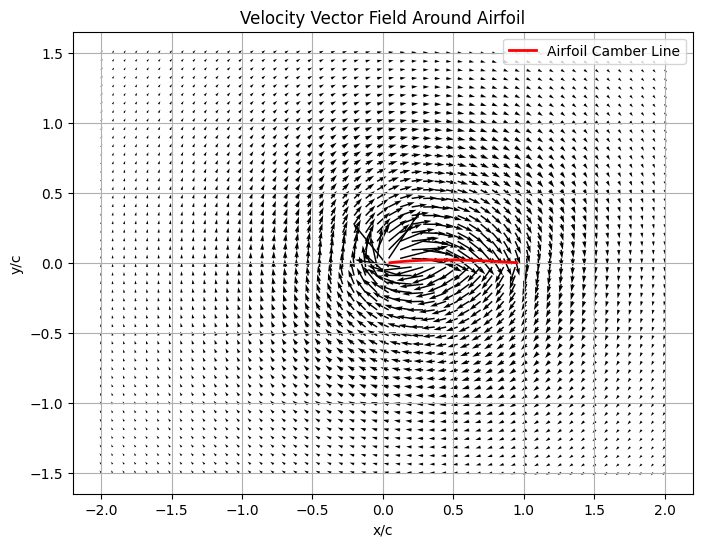

In [225]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Function to compute angle of the line connecting two points
def slope_theta(x1, y1, x2, y2):
    return np.arctan2((y2 - y1), (x2 - x1))

# Function to compute total and bound circulation
def compute_circulation_using_distrbution(circulation_theta):
    total_circulation = np.sum(circulation_theta)
    # _,Cl,_,_,_,_ =compute_airfoil_coefficients(alpha, naca)
   # Assuming all circulation contributes to lift
    return total_circulation
def circulation_using_line_integral(X, Y, Vx, Vy):
    # Ensure the contour is closed by appending the first element at the end
    X_closed = np.append(X, X[0])
    Y_closed = np.append(Y, Y[0])

    # Compute differentials
    dX = np.diff(X_closed)
    dY = np.diff(Y_closed)

    # Compute circulation integral using (Vx dy - Vy dx)
    V_dot_ds = Vx * dY - Vy * dX
    total_circulation = np.sum(V_dot_ds)

    return total_circulation

    # Compute dot product V ⋅ ds (Vx dx + Vy dy)
    V_dot_ds = Vx * dY - Vy * dX  # (Vx dy - Vy dx)

    # Sum over all segments to approximate the line integral
    Gamma = np.sum(V_dot_ds)

    return Gamma
# Function to compute velocity field
def compute_velocity_field(alpha, ufree, circulation_theta, zeta, camber_y):
    alpha_rad = np.radians(alpha)  # Convert angle of attack to radians

    # Define grid for visualization (4x chord length in x, 3x in y)
    x_range = np.linspace(-2, 2, 50)
    y_range = np.linspace(-1.5, 1.5, 50)
    X, Y = np.meshgrid(x_range, y_range)

    # Initialize velocity components
    U_total = np.zeros_like(X, ufree * np.cos(alpha_rad))
    V_total = np.zeros_like(Y, ufree * np.sin(alpha_rad))

    # Compute vortex-induced velocities
    for i in range(len(zeta)):
      for j in range(X.shape[0]):  # Iterate over rows (y-direction)
          for k in range(X.shape[1]):  # Iterate over columns (x-direction)
              x1, y1 = X[j, k], Y[j, k]  # Grid point

              # Compute vortex effect only if circulation exists
              if circulation_theta[i] != 0:
                  r = distance(x1, y1, zeta[i], camber_y[i])
                  theta_slope = slope_theta(zeta[i], camber_y[i], x1, y1)

                  if r > 1e-6:  # Avoid division by zero
                      induced_velocity = circulation_theta[i] / (2 * np.pi * r)
                      U_total[j, k] += induced_velocity * np.sin(theta_slope)
                      V_total[j, k] -= induced_velocity * np.cos(theta_slope)

    # Compute circulations
    # total_circulation, bound_circulation = compute_final_circulations(circulation_theta)
    dist_circ = compute_circulation_using_distrbution(circulation_theta)
    # line_cir = circulation_using_line_integral(X, Y, U_total, V_total)
    # Print results
    # print(f"Total Circulation: {line_cir:.4f}")
    print(f"Bound Circulation: {dist_circ:.4f}")
    print(X.shape)

    # Quiver plot for vector field
    plt.figure(figsize=(8, 6))
    plt.quiver(X, Y, U_total, V_total)  # Plot velocity vectors
    plt.plot(zeta, camber_y, 'r-', linewidth=2, label="Airfoil Camber Line")  # Airfoil outline
    plt.title("Velocity Vector Field Around Airfoil")
    plt.xlabel("x/c")
    plt.ylabel("y/c")
    plt.grid()
    plt.legend()
    plt.show()

# Example usage
alpha = 3  # Angle of attack in degrees
ufree = 20  # Freestream velocity
zeta = np.linspace(0.05, 0.95, 50)  # Control points along the chord
x, camber_y = generate_camber_line('NACA2412')  # Modify for cambered airfoil
theta = np.linspace(0, np.pi, len(zeta))  # Angular positions along chord
circulation_theta = compute_circulation(alpha, '2412', ufree)  # Example circulation values
# circulation_theta[-1]
compute_velocity_field(alpha, ufree, circulation_theta[-1], zeta, camber_y)
